In [16]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import models
from torchvision.transforms import v2

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
for name, params in resnet50.named_parameters():
    if 'bn' not in name:
        params.requires_grad = False

resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 2)
)

In [3]:
train_data_path = './train'
test_data_path = './test'
val_data_path = './val'

transform = v2.Compose([
    v2.Resize((64, 64)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=transform)


In [4]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers
)

In [5]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device


device(type='mps')

In [6]:
resnet = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [7]:
def find_lr(model=resnet, loss_fn=criterion, optimizer=optimizer, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    best_loss = None
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, target in train_loader:
        batch_num += 1
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        
        if best_loss is None or loss.item() < best_loss:
            best_loss = loss.item()

        if batch_num > 1 and loss.item() > 4 * best_loss:
            break

        losses.append(loss.item())
        log_lrs.append(math.log10(lr))
        loss.backward()
        optimizer.step()
        
        lr *= update_step
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses


logs,losses = find_lr()
    

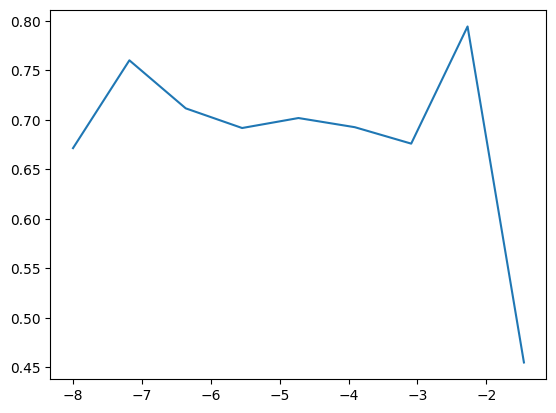

In [8]:
plt.plot(logs,losses)
plt.show()

In [9]:
found_lr = 1e-3
resnet = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': resnet.layer4.parameters(), 'lr': found_lr/3},
    {'params': resnet.layer3.parameters(), 'lr': found_lr/9}
], lr=found_lr)

for layer in [resnet.layer4, resnet.layer3]:
    for param in layer.parameters():
        param.requires_grad = True

In [10]:
epochs=20
def train(model=resnet, optimizer=optimizer, loss_fn=criterion, train_loader=train_loader, val_loader=val_loader, device=device, epochs=epochs):
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        for inputs, target in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        num_correct = 0.0
        num_examples = 0.0
        model.eval()
        for inputs, target in val_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)

            val_loss += loss.item()
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        val_loss /= len(val_loader)

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, Accuracy: {(num_correct/num_examples):.2f}")

train()

/var/folders/fd/xm_8gc6x0hncjzlyy0hscm7h0000gn/T/ipykernel_63877/4174151875.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)


Epoch: 1, Train Loss: 0.91, Val Loss: 1.48, Accuracy: 0.97
Epoch: 2, Train Loss: 0.17, Val Loss: 0.20, Accuracy: 0.97
Epoch: 3, Train Loss: 0.04, Val Loss: 0.13, Accuracy: 0.95
Epoch: 4, Train Loss: 0.03, Val Loss: 0.12, Accuracy: 0.96
Epoch: 5, Train Loss: 0.02, Val Loss: 0.11, Accuracy: 0.96
Epoch: 6, Train Loss: 0.00, Val Loss: 0.12, Accuracy: 0.96
Epoch: 7, Train Loss: 0.00, Val Loss: 0.15, Accuracy: 0.96
Epoch: 8, Train Loss: 0.00, Val Loss: 0.14, Accuracy: 0.96
Epoch: 9, Train Loss: 0.00, Val Loss: 0.23, Accuracy: 0.94
Epoch: 10, Train Loss: 0.00, Val Loss: 0.13, Accuracy: 0.94
Epoch: 11, Train Loss: 0.00, Val Loss: 0.15, Accuracy: 0.94
Epoch: 12, Train Loss: 0.00, Val Loss: 0.14, Accuracy: 0.94
Epoch: 13, Train Loss: 0.00, Val Loss: 0.24, Accuracy: 0.94
Epoch: 14, Train Loss: 0.00, Val Loss: 0.19, Accuracy: 0.93
Epoch: 15, Train Loss: 0.00, Val Loss: 0.17, Accuracy: 0.93
Epoch: 16, Train Loss: 0.01, Val Loss: 0.26, Accuracy: 0.94
Epoch: 17, Train Loss: 0.00, Val Loss: 0.24, Accu

In [11]:
def to_hsv(x):
    return x.convert('hsv')

HSVTansform = v2.Lambda(lambda x: to_hsv(x))


In [12]:
class Noise:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor: torch.Tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.std)
        return tensor.add(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"
        return repr


In [15]:
v2.Compose([
    Noise(1,2)
])

Compose(    Noise(mean=1, std=2))

In [21]:
labels = ['cat', 'fish']
x = Image.open('./test/fish/50081802_bf4d207cd5.jpg')
x = transform(x)
x = x.unsqueeze(0)

output = resnet(x.to(device))
pred = output.argmax()
print(f"Resnet Predicted: {labels[pred.item()]}")

Resnet Predicted: fish
